<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/Various_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기
- 서울에 해당하는 중구(140), 노원구(350)를 사용합니다.
- 다음의 카테고리(MCT_CAT_CD) 별로 모델을 학습하기 위해 총 9가지로 데이터를 분리합니다.
#### 온라인 서비스
1. 가구(30), 주방용구(32)
2. 가전(35), 사무통신(52)
3. 레저용품(20)
4. 신변잡화(44)
5. 음료식품(81)
6. 의복(42)
#### 오프라인 서비스
7. 숙박(10)
8. 유통업(40)
9. 요식업소(80)

In [284]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv', sep='\t')
data_foreigner = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_FOREIGNER.txt', sep='\t', encoding='cp949')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [285]:
# 국내
jung = data[data.GU_CD == 140].reset_index(drop = True)
nowon = data[data.GU_CD == 350].reset_index(drop = True)

seoul = pd.concat([jung, nowon])
seoul['STD_DD'] = seoul.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
seoul2019 = seoul[seoul.STD_DD < '2020-01-01']
seoul2020 = seoul[seoul.STD_DD > '2020-01-01']

In [286]:
# 외국인
jung_foreigner = data_foreigner[data_foreigner.GU_CD == 140].reset_index(drop = True)
nowon_foreigner = data_foreigner[data_foreigner.GU_CD == 350].reset_index(drop = True)

foreigner = pd.concat([jung_foreigner, nowon_foreigner])
foreigner['STD_DD'] = foreigner.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
foreigner2019 = foreigner[foreigner.STD_DD < '2020-01-01']
foreigner2020 = foreigner[foreigner.STD_DD > '2020-01-01']

In [287]:
# 국내 + 외국인 합치기
def indexing(df):
    return df.groupby(['STD_DD', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum()

def sum_korean_foreigner(df_korean, df_foreigner):
    df_foreigner.columns = ['USE_CNT2', 'USE_AMT2']
    df_all = pd.concat([df_korean, df_foreigner], axis=1)
    df_all['USE_CNT_SUM'] = np.nansum([df_all['USE_CNT'], df_all['USE_CNT2']], axis=0)
    df_all['USE_AMT_SUM'] = np.nansum([df_all['USE_AMT'], df_all['USE_AMT2']], axis=0)
    df_all = df_all[['USE_CNT_SUM', 'USE_AMT_SUM']]
    df_all.columns = ['USE_CNT', 'USE_AMT']
    return df_all.reset_index()

seoul2019 = indexing(seoul2019)
seoul2020 = indexing(seoul2020)
foreigner2019 = indexing(foreigner2019)
foreigner2020 = indexing(foreigner2020)

df_2019 = sum_korean_foreigner(seoul2019, foreigner2019)
df_2020 = sum_korean_foreigner(seoul2020, foreigner2020)

# 변수 추가하기
1. 전국 코로나 신규 확진자 수
2. 사회/경제 뉴스
3. 날짜 변수

In [288]:
# 카테고리 번호로 데이터 뽑아내기
def set_category(df, category_num):
    return df[df.MCT_CAT_CD == category_num].groupby('STD_DD').sum().drop('MCT_CAT_CD', axis=1).reset_index()

In [289]:
# 코로나
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid = covid.groupby('date').sum().reset_index()
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-01-31']
covid = covid.rename(columns = {'date': 'STD_DD'})
covid['covid'] = 0
covid['covid'][1:] = covid['confirmed'].values[1:] - covid['confirmed'][:-1].values
covid = covid[1:]
df_2020 = pd.merge(df_2020, covid[['STD_DD', 'covid']])
df_2019['covid'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [290]:
# 뉴스
news = pd.read_csv('/content/drive/My Drive/news_predict.csv')
news['STD_DD'] = news['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
news['STD_DD'] = news['STD_DD'] - timedelta(days = 7)

# Train, Test 데이터 분리
- Test set: 5월 마지막 주
- rolling window 적용하기

In [335]:
# 7일 동안의 데이터를 바탕으로 다음 일주일 매출을 예측 (rolling window)
def preprocessing(df):
    amt_X, amt_y = [], []
    cnt_X, covid_X, news_X = [], [], []

    for i in range(len(df)-14+1):
        # 사용하는 feature 값
        amt_X.append(df.USE_AMT[i:i+7].values)
        cnt_X.append(df.USE_CNT[i:i+7].values)
        covid_X.append(df.covid[i:i+7].values)
        news_X.append(df.news[i:i+7].values)
        # 예측값
        amt_y.append(df.USE_AMT[i+7:i+14].values)

    amt_X = np.array(amt_X)
    cnt_X = np.array(cnt_X)
    covid_X = np.array(covid_X)
    news_X = np.array(news_X)

    amt_y = np.array(amt_y)

    X = np.concatenate([amt_X.reshape(-1, 7, 1), cnt_X.reshape(-1, 7, 1), covid_X.reshape(-1, 7, 1), news_X.reshape(-1, 7, 1)], axis=2)
    y = amt_y

    return X, y

In [343]:
n_category = 20

# 2019
df = set_category(df_2019, n_category)
df = pd.merge(df, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})

# 2020
df2 = set_category(df_2020, n_category)
df2 = pd.merge(df2, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})

# 정규화
# cols = list(df.columns)[1:] # 날짜 제외
# for col in cols:
#     if col != 'news':
#         scaler = MinMaxScaler(feature_range = (0, 1))
#         scaled_values = scaler.fit_transform(df[col].values.reshape(-1, 1))
#         scaled_values2 = scaler.fit_transform(df2[col].values.reshape(-1, 1))
#         df[col] = scaled_values
#         df2[col] = scaled_values2
#     else:
#         scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
#         scaled_values = scaler.fit_transform(df[col].values.reshape(-1, 1))
#         scaled_values2 = scaler.fit_transform(df2[col].values.reshape(-1, 1))
#         df[col] = scaled_values
#         df2[col] = scaled_values2

X, y = preprocessing(df)
X2, y2 = preprocessing(df2)

# 2019, 2020 합치기
X = np.concatenate([X, X2])
y = np.concatenate([y, y2])

In [345]:
# XGBoost는 3차원을 인식 못하므로 2차원으로 펴주는 과정 필요
X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]
X_train = X_train.reshape(len(X_train), -1) 
X_test = X_test.reshape(len(X_test), -1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((194, 28), (194, 7), (7, 28), (7, 7))

# 1. XGBoost

### Train
Grid Search CV 이용해서 최적의 Parameter 찾기

In [346]:
param_grid = {'estimator__min_samples_split':[10, 50],
              'estimator__min_samples_leaf':[50, 150],
              'estimator__max_depth': [5, 6, 7, 8, 9, 10]}

gb = xgb.XGBRegressor(objective='reg:squarederror')
gs = GridSearchCV(MultiOutputRegressor(gb), param_grid=param_grid, cv = 3)
gs.fit(X_train, y_train)
# gs.best_params_

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def mae(y_true, y_pred):
#     y_true = np.array(y_true)
#     y_true = y_true.reshape(1, -1)[0]  
#     y_pred = np.array(y_pred)
#     y_pred = y_pred.reshape(1, -1)[0]
#     mae = np.mean(np.abs(y_true - y_pred))
#     return mae

kf = KFold(n_splits=5)
scores = []
for train_index, test_index in kf.split(X_train):
    gs_xgb = gs.best_estimator_
    gs_xgb.fit(X_train[train_index], y_train[train_index])
    pred = gs_xgb.predict(X_train[test_index])
    scores.append(mean_absolute_percentage_error(y_train[test_index], pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase memory consumption")
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:614: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and

In [69]:
# XGBoost validation score
np.mean(scores)

27.065277896515443

In [166]:
# +covid
np.mean(scores)

26.03863612648704

In [219]:
# +news
np.mean(scores)

26.09957602764095

In [347]:
# +news(수정)
np.mean(scores)

22.488918985975022

### Prediction

In [82]:
# XGBoost test score
pred = gs_xgb.predict(X_test)
mean_absolute_percentage_error(y_test, pred)

17.655689849170408

In [167]:
# +covid
pred = gs_xgb.predict(X_test)
mean_absolute_percentage_error(y_test, pred)

16.2713220694719

In [220]:
# +news
pred = gs_xgb.predict(X_test)
mean_absolute_percentage_error(y_test, pred)

11.556025443796292

In [238]:
# +news(수정)
pred = gs_xgb.predict(X_test)
mean_absolute_percentage_error(y_test, pred)

22.996352719304674

### --------- 그래프 다시 그려보기 ----------

In [ ]:
plt.plot(np.arange(7), X_test[-1,:,0], # 매출
             marker = 'o', color = 'black', label = 'True_input')
plt.plot(np.arange(8,15), y_test[-1],
            marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
plt.plot(np.arange(8,15), pred[-1],
            color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)

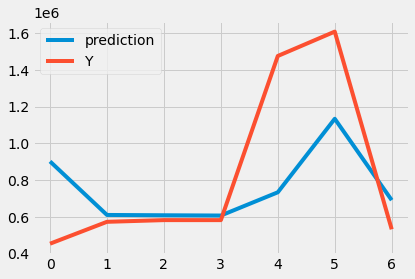

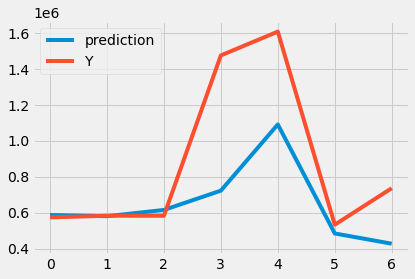

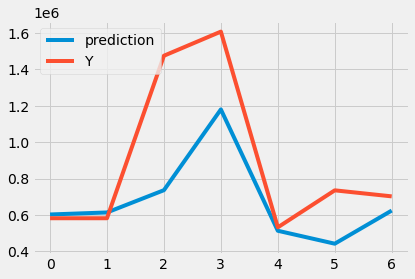

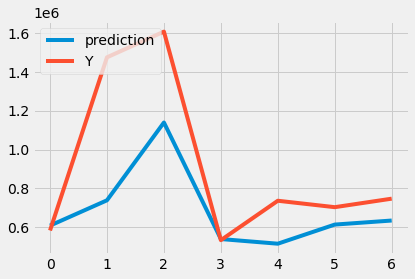

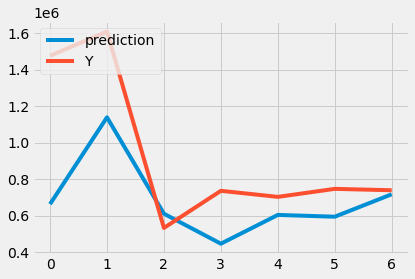

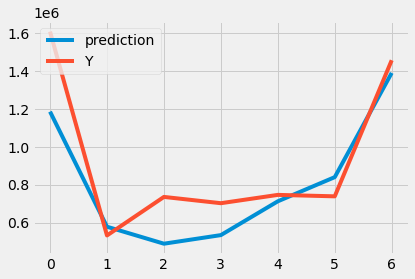

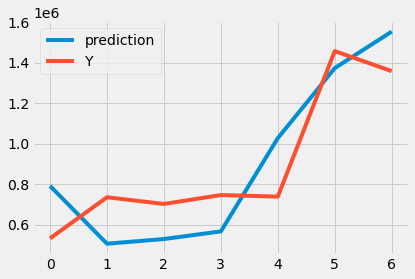

In [244]:
for i in range(7):
    plt.plot(pred[i], label='prediction')
    plt.plot(y_test[i], label='Y')
    plt.legend(loc = 'upper left')
    plt.show()

# 2. LSTM

In [348]:
n_category = 20

# 2019
df = set_category(df_2019, n_category)
df = pd.merge(df, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})

# 2020
df2 = set_category(df_2020, n_category)
df2 = pd.merge(df2, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})

# 정규화
cols = list(df.columns)[1:] # 날짜 제외
for col in cols:
    if col != 'news':
        scaler = MinMaxScaler(feature_range = (0, 1))
        scaled_values = scaler.fit_transform(df[col].values.reshape(-1, 1))
        scaled_values2 = scaler.fit_transform(df2[col].values.reshape(-1, 1))
        df[col] = scaled_values
        df2[col] = scaled_values2
    else:
        scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
        scaled_values = scaler.fit_transform(df[col].values.reshape(-1, 1))
        scaled_values2 = scaler.fit_transform(df2[col].values.reshape(-1, 1))
        df[col] = scaled_values
        df2[col] = scaled_values2

X, y = preprocessing(df)
X2, y2 = preprocessing(df2)

# 2019, 2020 합치기
X = np.concatenate([X, X2])
y = np.concatenate([y, y2])

In [349]:
X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((194, 7, 4), (194, 7), (7, 7, 4), (7, 7))

In [350]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X = torch.FloatTensor(X_train).to(device)
y = torch.FloatTensor(y_train).to(device)
# valid_cycle_x = torch.FloatTensor(valid_cycle_x).to(device)
# valid_cycle_y = torch.FloatTensor(valid_cycle_y).to(device)

class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )
        
    def forward(self, x_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out, _ = self.lstm(x_time, hidden)
        out = out[:, -1, :] # LSTM의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [351]:
# hidden state : 전달과정 중간 출력의 차원
model_trend = LSTMModel_trend(input_size = 4, hidden_size = 32).to(device)
optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)

# Train model
num_epochs  = 200
hist = np.zeros(num_epochs)

# Number of steps to unroll
look_back = 7
seq_dim =look_back - 1

for t in range(num_epochs):
    pred = model_trend(X)
    loss = criterion(pred, y)

    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch  10 MSE:  0.07776794582605362
Epoch  20 MSE:  0.04935727268457413
Epoch  30 MSE:  0.04626406729221344
Epoch  40 MSE:  0.04399913549423218
Epoch  50 MSE:  0.04227685555815697
Epoch  60 MSE:  0.04135407879948616
Epoch  70 MSE:  0.04107660800218582
Epoch  80 MSE:  0.040841978043317795
Epoch  90 MSE:  0.04063991457223892
Epoch  100 MSE:  0.040421098470687866
Epoch  110 MSE:  0.04014406353235245
Epoch  120 MSE:  0.03960728645324707
Epoch  130 MSE:  0.037234801799058914
Epoch  140 MSE:  0.03158525377511978
Epoch  150 MSE:  0.02627488784492016
Epoch  160 MSE:  0.02046624943614006
Epoch  170 MSE:  0.01862180233001709
Epoch  180 MSE:  0.01724066026508808
Epoch  190 MSE:  0.015904776751995087


In [358]:
model_trend(torch.FloatTensor(X_test).to(device)) # prediction

tensor([[0.2064, 0.1826, 0.2192, 0.2438, 0.3928, 0.5606, 0.4528],
        [0.1583, 0.2064, 0.3088, 0.3943, 0.4934, 0.4220, 0.2959],
        [0.2125, 0.3138, 0.3765, 0.3553, 0.3803, 0.3405, 0.2759],
        [0.2755, 0.3815, 0.3766, 0.2349, 0.2253, 0.3368, 0.3365],
        [0.3270, 0.3327, 0.2917, 0.1725, 0.1907, 0.3978, 0.4351],
        [0.4872, 0.2272, 0.1506, 0.2073, 0.3285, 0.6639, 0.7076],
        [0.3637, 0.2513, 0.2564, 0.3117, 0.5687, 0.9757, 0.7528]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [356]:
y_test # real y

array([[0.15185775, 0.23938035, 0.24618622, 0.24614505, 0.90258771,
        1.        , 0.2094216 ],
       [0.23938035, 0.24618622, 0.24614505, 0.90258771, 1.        ,
        0.2094216 , 0.35887274],
       [0.24618622, 0.24614505, 0.90258771, 1.        , 0.2094216 ,
        0.35887274, 0.33451323],
       [0.24614505, 0.90258771, 1.        , 0.2094216 , 0.35887274,
        0.33451323, 0.36675728],
       [0.90258771, 1.        , 0.2094216 , 0.35887274, 0.33451323,
        0.36675728, 0.36116097],
       [1.        , 0.2094216 , 0.35887274, 0.33451323, 0.36675728,
        0.36116097, 0.88900172],
       [0.2094216 , 0.35887274, 0.33451323, 0.36675728, 0.36116097,
        0.88900172, 0.81637393]])

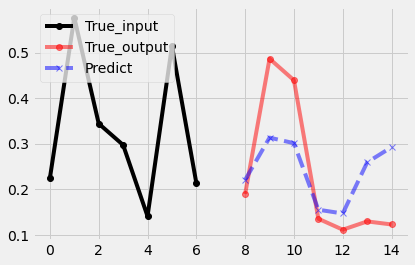

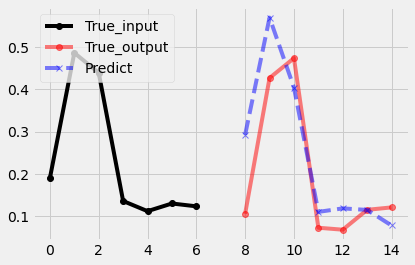

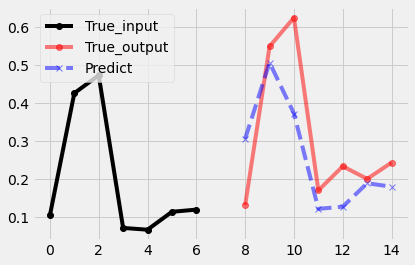

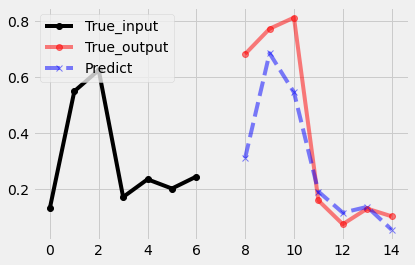

In [360]:
for i in range(4):
    i = i*7
    plt.plot(np.arange(7), X.cpu().detach().numpy()[i,:,0],
             marker = 'o', color = 'black', label = 'True_input')
    plt.plot(np.arange(8,15), y.cpu().detach().numpy()[i],
             marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
    plt.plot(np.arange(8,15), pred.cpu().detach().numpy()[i],
             color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)
    plt.legend(loc = 'upper left')
    plt.show()

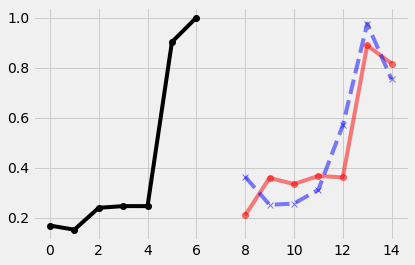

In [367]:
plt.plot(np.arange(7), X_test[-1,:,0], # 매출
             marker = 'o', color = 'black', label = 'True_input')
plt.plot(np.arange(8,15), y_test[-1],
            marker = 'o', color = 'red', label = 'True_output', alpha = 0.5)
plt.plot(np.arange(8,15), model_trend(torch.FloatTensor(X_test).to(device)).cpu().detach().numpy()[-1],
            color = 'blue', label = 'Predict', marker = 'x', ls = '--', alpha = 0.5)

In [373]:
# LSTM 오차
mean_absolute_percentage_error(y_test, model_trend(torch.FloatTensor(X_test).to(device)).cpu().detach().numpy())

37.33298115622866